# 交易系统(Aberration)——趋势跟踪系统股票修改版

---

### 1.基本原理

    股票价格多围绕某一价格上下波动。当股价远离基准价格超过一定幅度则可能形成长期趋势，而短期股价偏离基准价格过多则可能因过度偏离均值而形成大幅回撤甚至趋势终止。
    
    由此以观察期内均线作为基准价格，以观察期内标准差的一定倍数作为开仓价或止盈价，采用移动止损方式进行止损构建此策略。


- 开仓条件    
  
  当日最高价 > 均价 +　开仓触发倍数 × 观察期内标准差最大值


- 止盈条件  
  
  当天最高价 > 均价 + 止盈触发倍数 × 观察期内标准差最大值
    

- 止损条件  
  
  同样结合了移动止损和固定止损两种止损模式；
  
  当天最低价 < max(均价， 开仓价 - 止损触发倍数 × 开仓时观察期内标准差最大值) 
  
  均价：移动止损；开仓价 - 止损触发倍数 × 开仓时观察期内标准差最大值：固定止损
  
  注意：
  
  
- 考虑了开仓当天也触发了平仓信号的近似处理；  


- 用观察期内标准差的最大值开仓的原因是：在震荡行情的时候，避免频繁开仓；更加稳定
  

---

### 2.策略实现

### 2.1 数据获取

In [1]:
import pandas as pd
import numpy as np
import tushare as ts
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
code = '002397'
length = 10             #  参考周期长度，用于确定计算标准差及移动平均的周期
open_trigger = 0.5      #  价格向上偏离均线0.5倍观察期内标准差的最大值开仓；
stopwin_trigger = 3     #  价格向上偏离均线3倍观察期内标准差的最大值止盈；
stoplose_trigger = 1    #  移动止损；跌破均值移动止损；固定止损：开仓价向下偏离观察期内标准差的最大值；

In [3]:
data = ts.get_k_data(code, '2012-01-01', '2017-01-01')

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


C:\Users\Yichao Hou\anaconda3\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
C:\Users\Yichao Hou\anaconda3\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
C:\Users\Yichao Hou\anaconda3\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,


In [4]:
data.head()

,date,open,close,high,low,volume,code
0,2012-01-04,4.973,4.696,4.973,4.657,1512.0,002397
1,2012-01-05,4.586,4.445,4.586,4.275,3389.0,002397
2,2012-01-06,4.282,4.404,4.430,4.157,4425.0,002397
3,2012-01-09,4.273,4.461,4.473,4.143,2581.0,002397
4,2012-01-10,4.382,4.648,4.657,4.268,2586.0,002397


### 2.2 策略数据处理

In [5]:
data['pct_change'] = data['close'].pct_change()

In [6]:
data['ma'] = data['close'].rolling(window=length, min_periods=3).mean()

In [7]:
data['std'] = data['close'].rolling(window=length, min_periods=3).std()

In [8]:
data.head()

,date,open,close,high,low,volume,code,pct_change,ma,std
0,2012-01-04,4.973,4.696,4.973,4.657,1512.0,002397,NaN,NaN,NaN
1,2012-01-05,4.586,4.445,4.586,4.275,3389.0,002397,-0.053450,NaN,NaN
2,2012-01-06,4.282,4.404,4.430,4.157,4425.0,002397,-0.009224,4.5150,0.158085
3,2012-01-09,4.273,4.461,4.473,4.143,2581.0,002397,0.012943,4.5015,0.131870
4,2012-01-10,4.382,4.648,4.657,4.268,2586.0,002397,0.041919,4.5308,0.131661


以观察期内标准差最大值作为标准差限制指标

In [9]:
data['std_limit'] = data['std'].rolling(window=length).max()      #观察期内标准差的最大值

由于实盘中当天的日线级别参考指标未实现，例如当日ma计算时使用当日收盘价，因此应使用昨日参考指标指导当日交易

In [10]:
data['yes_ma'] = data['ma'].shift(1)

In [11]:
data['yes_std_limit'] = data['std_limit'].shift(1)            

计算当日开仓价和止盈价

In [12]:
data['long_open_price'] = data['yes_ma'] + data['yes_std_limit']*open_trigger    #计算每一天满足条件的开仓价；

In [13]:
data['long_stopwin_price'] = data['yes_ma'] + data['yes_std_limit']*stopwin_trigger   #计算每一天满足条件的止盈价；价格高于3倍观察期内标准差最大值止盈；

In [14]:
data.loc[10:15, ['date', 'pct_change', 'ma', 'std', 'yes_std_limit','long_open_price', 'long_stopwin_price']]

,date,pct_change,ma,std,yes_std_limit,long_open_price,long_stopwin_price
10,2012-01-18,-0.027437,4.2179,0.364081,NaN,NaN,NaN
11,2012-01-19,0.041644,4.1611,0.368988,NaN,NaN,NaN
12,2012-01-20,0.022182,4.1170,0.363037,0.368988,4.345594,5.268065
13,2012-01-30,-0.009084,4.0636,0.345674,0.368988,4.301494,5.223965
14,2012-01-31,0.000000,3.9915,0.279000,0.368988,4.248094,5.170565
15,2012-02-01,-0.017316,3.9226,0.200266,0.368988,4.175994,5.098465


### 2.3 计算开仓、止盈信号

In [15]:
data['long_open_signal'] = np.where(data['high'] > data['long_open_price'], 1, 0)

In [16]:
data['long_stopwin_signal'] = np.where(data['high'] > data['long_stopwin_price'], 1, 0)

In [17]:
data[['date', 'long_open_signal', 'long_stopwin_signal']].head()

,date,long_open_signal,long_stopwin_signal
0,2012-01-04,0,0
1,2012-01-05,0,0
2,2012-01-06,0,0
3,2012-01-09,0,0
4,2012-01-10,0,0


### 3 策略逻辑

#### 策略要点：  
    1. 当天有持仓，满足平仓条件进行平仓后，当天不再开仓；
    2. 当天无持仓，满足开仓条件则进行开仓。开仓当日如果同时满足平仓条件，以第二日开盘价平仓；

In [18]:
flag = 0    # 记录持仓情况，0代表空仓，1代表持仓；

In [19]:
# 前12个数据因均值计算无效所以不作为待处理数据
# 终止数据选择倒数第二个以防止当天止盈情况会以第二天开盘价平仓导致无数据情况发生
# 最后一天不再进行操作；可能会面临最后一天开仓之后当天触发平仓，要用下一天开盘价卖出，无法得到； 

for i in range(12, (len(data)-1)):
        # 有持仓进行平仓
        if flag == 1:
            # 计算止损价格，取均线和开仓价下移一定倍数标准差，两者的最大值作为止损价
            stoplose_price = max(data.loc[i,'yes_ma'], long_open_price - long_open_delta * stoplose_trigger)    
            # 多头止盈并计算当日收益率
            if data.loc[i, 'long_stopwin_signal']: 
                data.loc[i, 'return'] = data.loc[i, 'long_stopwin_price']/data.loc[i-1, 'close'] - 1
                flag = 0
                
            
            # 多头移动止损并计算当日收益率
            elif data.loc[i, 'low'] < stoplose_price:    
            # 考虑到当天开盘价就低于止损价，无法止损的情况；
            # 谨慎起见，在计算收益时，取止损价和开盘价的最小值；
                data.loc[i, 'return'] = min(data.loc[i, 'open'], stoplose_price)/data.loc[i-1, 'close'] - 1
                flag = 0
            # 多头持仓并计算收益率
            
            else: 
                data.loc[i, 'return'] = data.loc[i, 'close']/data.loc[i-1, 'close'] - 1

        
        
        
        # 无持仓进行开仓
        else:
            if data.loc[i, 'long_open_signal']:    
                #开仓时标记flag=1
                flag = 1
                # 需要比较当天的开盘价和开仓价，当开盘价高于开仓价时，只能以开盘价进行开仓，不能用开仓价;
                # 否则对导致策略收益高估；
                # 记录开仓价
                long_open_price = max(data.loc[i, 'open'], data.loc[i, 'long_open_price'])    
#                 long_open_price = data.loc[i, 'long_open_price']  #存在问题；
                # 记录开仓时的10天内的标准差的最大值；是为了计算固定止损的价格；
                long_open_delta = data.loc[i, 'yes_std_limit']
                # 记录当天盈利情况
                data.loc[i, 'return'] = data.loc[i, 'close']/long_open_price - 1
                
                                
                # 计算止损价：多头移动止损，以均线和开仓价减一定倍数标准差，两者的最大值作为止损点
                stoplose_price = max(data.loc[i,'yes_ma'], long_open_price - long_open_delta * stoplose_trigger)
                # 如果开仓当天同时满足平仓条件，则以第二天开盘价平仓
                # 这里做了一定的近似处理；
                if (data.loc[i, 'low'] < stoplose_price     # 满足止损条件
                 or data.loc[i, 'long_stopwin_signal']):    # 满足止盈条件
                        # 记录此次操作盈利情况并将收益记录在开仓日
                        data.loc[i, 'return'] = data.loc[i+1, 'open']/long_open_price - 1    
                        flag = 0
                

In [20]:
data.tail()

,date,open,close,high,low,volume,code,pct_change,ma,std,std_limit,yes_ma,yes_std_limit,long_open_price,long_stopwin_price,long_open_signal,long_stopwin_signal,return
1200,2016-12-26,7.524,7.584,7.614,7.434,22182.0,002397,0.006637,7.639,0.082630,0.444123,7.634,0.444123,7.856062,8.966370,0,0,NaN
1201,2016-12-27,7.594,7.604,7.644,7.564,14229.0,002397,0.002637,7.644,0.078316,0.444123,7.639,0.444123,7.861062,8.971370,0,0,NaN
1202,2016-12-28,7.594,7.544,7.644,7.514,16192.0,002397,-0.007891,7.646,0.075100,0.374500,7.644,0.444123,7.866062,8.976370,0,0,NaN
1203,2016-12-29,7.514,7.554,7.604,7.514,13150.0,002397,0.001326,7.636,0.080388,0.266667,7.646,0.374500,7.833250,8.769499,0,0,NaN
1204,2016-12-30,7.554,7.534,7.584,7.514,11531.0,002397,-0.002648,7.616,0.078145,0.234521,7.636,0.266667,7.769333,8.436000,0,0,NaN


### 4 计算策略收益率并可视化

In [21]:
data['return'].fillna(0, inplace=True)
data['strategy_return'] = (data['return'] + 1).cumprod()
data['stock_return'] = (data['pct_change'] + 1).cumprod()

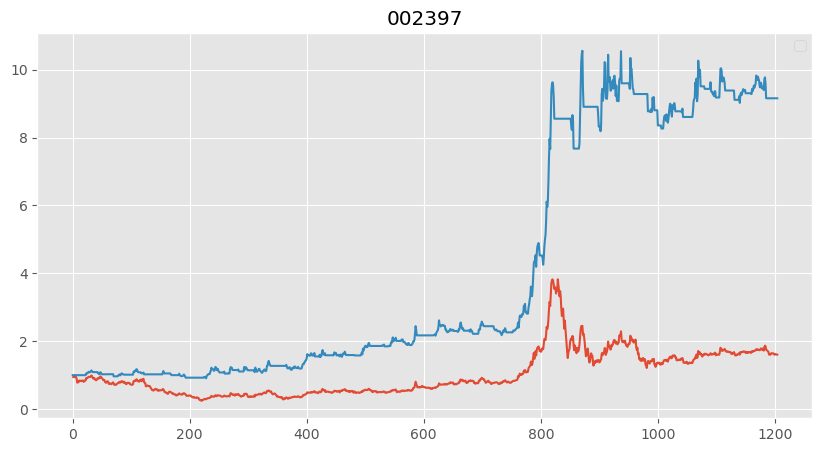

In [22]:
matplotlib.style.use('ggplot')
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(data.stock_return)
ax.plot(data.strategy_return)
plt.title(code)
plt.legend()
plt.show()

---

### 5.策略编写与实盘差异

#### 5.1 策略账号操作对盘面价格的影响

    未考虑交易滑点。实盘交易中，如果满足操作条件时实盘成交量较小，策略账号进行操作可能会对盘面价格产生一定影响，导致当次操作成交均价偏离期望成交价，由此产生滑点（一般对收益产生负影响, 策略回测表现优于实盘表现）。
    
#### 5.2 交易费用
     
    未考虑交易手续费。对于交易频率较低的策略，交易手续费对回测结果的影响较小；对于交易频率较高的策略，交易手续费可能决定策略回测结果是否为正。（策略回测表现优于实盘表现）
    
#### 5.3 策略回测执行价实盘是否执行

1.期望开仓价是否执行  

    本策略回测中期望开仓价定为均线价格加一定倍数的标准差，实盘中可能面临以下情况：
 - 开仓执行当日开盘时涨停，实盘中无法成交。
 - 期望开仓价恰好为涨停价，实盘中可能无法成交。
 - 期望开仓价距离涨停价较近，实盘中价格上涨突破期望开仓价时因交易不活跃等原因直接跳价到涨停价或因交易系统产生并发送交易信号时间慢于价格快速上涨到涨停的时间，实盘中无法成交。  
    
    
2.期望止损价是否执行  

    本策略回测中期望止损价定为均线价格和开仓价格的最大值，实盘中可能面临以下情况：
 - 止损执行当日开盘价低于期望止损价，满足止损条件，应以开盘价执行。（期望止损价更优于开盘价，策略回测表现优于实盘表现）
 - 止损执行当日开盘时跌停，实盘中无法成交。
 - 期望止损价恰好为跌停价，实盘中可能无法成交。
 - 期望止损价距离跌停板较近，实盘中价格下跌突破期望止损价时因交易不活跃等原因直接跳价到跌停价或因交易系统产生并发送交易信号时间慢于价格快速下跌到跌停的时间，实盘中无法成交。  
    
    
#### 5.4 策略信号执行优先级

    因策略回测使用日线级数据，当日内同时满足多个操作条件，如同时满足开仓信号、止损信号，回测将无法辨别信号出现先后顺序，由此使用信号执行优先级方式近似计算策略收益情况。该种方式将产生一定偏差。
    
1.开仓当日同时满足开仓、止损条件

    策略回测中，如开仓当日同时满足开仓、止损条件，则假设进行一次完整交易，先开仓，后以第二日开盘价平仓。
    实盘中当日如果先满足止损条件（此时未持仓），后满足开仓条件，则第二日不进行平仓操作。（因策略收益特点类似看涨期权，因此实盘表现可能优于策略回测表现）
    
2.平仓当日同时满足止盈、止损条件

    策略回测中，如平仓当日同时满足止盈、止损条件，则以止盈价进行平仓。
    实盘中当日如果先满足止损条件（此时有持仓），后满足止盈条件，则以止损价进行平仓操作。（策略回测表现优于实盘表现）

声明：本资料仅供内部学习交流使用，切勿外传。